In [1]:
import numpy as np

import importlib
import os, sys
sys.path.append(os.path.abspath(".."))

In [2]:
# --------------------------
# Module reload utility cell
# --------------------------
import importlib
import models.heston
import models.doubleheston
import plotting.plot_utils
import utils.hedging

# Reload modules to pick up edits
importlib.reload(models.heston)
importlib.reload(models.doubleheston)
importlib.reload(plotting.plot_utils)
importlib.reload(utils.hedging)

<module 'utils.hedging' from '/home/machine/Desktop/ErdosFinance2025/utils/hedging.py'>

## Options

A **call option** is a financial contract giving the holder the right, but not the obligation, to buy an asset at a predetermined price \(K\) (the strike price) at a specified future time $T$ (the maturity).

The payoff of a **European call option** at maturity depends on the terminal stock price \(S_T\):

$$
\text{Payoff at } T: (S_T - K)^+ = \max(S_T - K, 0)
$$

- If $S_T > K$, the option is **in the money**, and the holder profits $S_T - K$.  
- If $S_T \le K$, the option expires worthless.

<!-- Similarly, a **European put option** has payoff:

$$
\boxed{(K - S_T)^+ = \max(K - S_T, 0)}
$$ -->

The **option price today** is the discounted expected value of the payoff under the **risk-neutral measure** $\mathbb{Q}$:

$$
C(K) = e^{-r \tau} \mathbb{E}^{\mathbb{Q}}[(S_T - K)^+]%, \quad P(K) = e^{-r \tau} \mathbb{E}^{\mathbb{Q}}[(K - S_T)^+]
$$

where $\tau = T - t$.



## Heston Model

Before the implementation of the double Heston model, having a working implementation of the standard Heston model (Heston, 1993) is convenient.

In the Heston model the evolution of the stock price $S_t$ and its variance $v_t$ is defined by the following system of stochastic differential equations (under the risk neutral measure): 

$$
\begin{aligned}
d S_t &= (r-q) S_t dt + \sqrt v_t S_t d W_{1, t} \\
d v_t & = \kappa (\theta - v_t) dt + \sigma \sqrt v_t d W_{2, t},
\end{aligned}
$$
where  $W_{1,t}, W_{2,t}$ are Brownian motions, $E^{\mathbb{Q}}[dW_{1,t},dW_{2,t}]= \rho dt$ for the risk-neutral measure $\mathbb{Q}$ and

$r$: risk-free interest rate  
$q$: continuous dividend yield  
$\kappa >0$: mean reversion speed for the variance  
$\theta>0$: mean reversion level for the variance  
$\sigma > 0$: volatility of the variance  
$\rho \in [-1,1]$: correlation between $d W_{1,t}$ and $d W_{2,t}$

### Monte Carlo Simulations (Heston)

To calculate the price numerically, we use Monte Carlo simulations. In Monte Carlo pricing $S_T$ is obtained by simulating the underlying stochastic process (i.e. Heston SDE) up to maturity $N$ times, which results in $N$ stock price paths. The price is then calculated as the discounted average of the payoffs for all the paths. We use an Euler discretization for the system of SDEs.

#### Brownian Motions

In the Euler discretization we will have $dW_{1,t}$ and $dW_{2,t}$ corresponding to differences in time of the two Brownian motions. To guarantee that $dW_{1,t}$ and $dW_{2,t}$ have $\rho$ correlation as required by the model, we generate random variables $Z_1, Z_2 \sim \mathcal{N}(0,1)$, define
$$
\boxed{
\begin{aligned}
Z_V &= Z_1 \\
Z_S &= \rho Z_V + \sqrt {1-\rho^2} Z_2,
\end{aligned}
}
$$
and make
\begin{aligned}
dW_{1,t} &= \sqrt{dt} Z_S \\
dW_{2,t} &= \sqrt{dt} Z_V.
\end{aligned}

By construction, $E[Z_V]=E[Z_S]=0$ and therefore $E[Z_V Z_S]=\rho E[Z_1^2] + \sqrt{1-\rho^2} E[Z_1 Z_2]= \rho$

#### Euler Scheme (Heston)

Using Ito's lemma for the equation for the stock price yields in integral form
$$\ln S_{t+dt} = \ln S_t + \int_{t}^{t+dt} \left( r - q - \frac{1}{2} v_u \right) du + \int_{t}^{t+dt} \sqrt v_u d W_{1,u}$$.
The Euler discretization for the process $ln S_t$ is then
\begin{align}
\ln S_{t+dt} &\approx \ln S_t + \left( r - q - \frac{1}{2} v_t \right) dt + \sqrt v_t (W_{1,t+dt} - W_{1,t}) \\
 & = \ln S_t + \left( r - q - \frac{1}{2} v_t \right) dt + \sqrt v_t \sqrt{dt} Z_s.
\end{align}
From which we obtain
$$\boxed{S_{t+dt} = S_t \exp \left( \left( r - q - \frac{1}{2} v_t \right) dt + \sqrt{v_t} \sqrt{dt} Z_S \right).}$$

The integral form for the SDE for $v_t$ and corresponding Euler discretization are
\begin{align}
v_{t+dt} &= v_t + \int_{t}^{t+dt} \kappa (\theta - v_u) du + \int_{t}^{t+dt} \sigma \sqrt{v_u} dW_{2,u} \\
& \approx v_t+ \kappa (\theta -v_t) dt + \sigma \sqrt{v_t} (W_{2,t+dt}-W_{2,t}),
\end{align}
which gives the following Euler discretization for the variance
$$ \boxed{v_{t+dt} = v_t + \kappa (\theta - v_t)dt + \sigma \sqrt{v_t} \sqrt{dt} Z_V}.$$

To avoid negative variances, we adopt the full truncation scheme, i.e. $v_t$ is replaced by $v_t^+= \max(0,v_t)$.

#### Monte Carlo Price

The Monte Carlo price is calculated using
$$\boxed{ C(K) = e^{-r \tau} \frac{1}{N} \sum_{i=1}^N \max(S^{(i)}_T-K,0) }$$
where $S^{(i)}_T$ is the terminal stock price in the stock price path $i=1, \ldots, N$.

### Exact price (Heston)

The price of a call option for the Heston model is given by the formula
$$\boxed{ C(K) = S_t e^{-q \tau} P_1 - K e^{-r \tau} P_2}$$
where 
$$ \boxed{ P _j = P(\ln S_T > K) = \frac{1}{2} + \frac{1}{\pi} \int_{0}^{\infty} \Re \left[\frac{e^{-i \phi \ln K} f_j (\phi; x_t,v_t)}{i \phi}\right] d \phi }$$.  
The functions $f_1, f_2$ are characteristic functions for the logarithm of the terminal stock price, $x_T = \ln S_T$:

$$\boxed{f_j(\phi; x_t,v_t) = \exp (C_j(\tau, \phi)+D_j(\tau, \phi) v_t+i \phi x_t),}$$
where $\tau = T-t$ is the time to maturity.

The expressions for $C_j(\tau, \phi)$ and $D_j(\tau, \phi)$ are
$$
\boxed{
\begin{align}
C_j (\tau, \phi) &= (r-q) i \phi \tau + \frac{\kappa \theta}{\sigma^2} \left[ (b_j - \rho \sigma i \phi - d_j) \tau - 2 \ln \left( \frac{1- c_j e^{-d_j \tau}}{1-c_j} \right) \right] \\
D_j(\tau, \phi) &= \frac{b_j - \rho \sigma i \phi-d_j}{\sigma^2} \left(\frac{1-e^{-d_j \tau}}{1-c_j e^{-d_j \tau}} \right).
\end{align}
}$$
Here, we have
$$
\boxed{
\begin{align}
c_j &= \frac{b_j - \rho \sigma i \phi - d_j}{b_j - \rho \sigma i \phi + d_j} \\
b_1 & = \kappa - \rho \sigma \\
b_2 &= \kappa \\
d_j &= \sqrt{(\rho \sigma i \phi - b_j)^2 - \sigma^2 (2 u_j i \phi - \phi^2)} \\
u_1 &= \frac{1}{2} \\
u_2 &=- \frac{1}{2}.
\end{align}
}
$$

These formulas use the Heston trap formulation for numerical stability. We take the principal branch of the complex root and logarithm in $d_j$ and $C_j$. The integral in $P_j$ is calculated numerically using the trapezoidal rule.

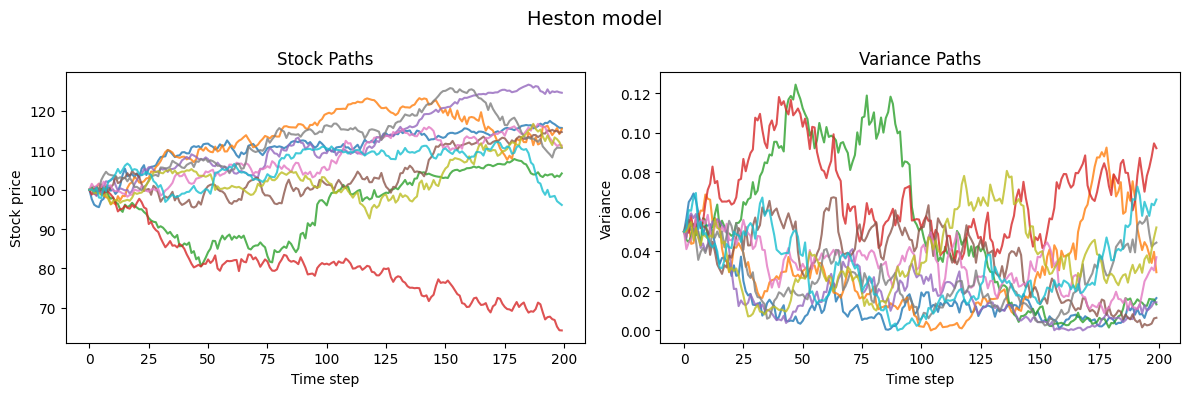

In [3]:
Heston_test=models.heston.Heston(r=0.03, q=0.02, 
                                 kappa=5.0, 
                                 theta=0.05, 
                                 sigma=0.5, 
                                 rho=-0.8)

S_example, V_example = Heston_test.simulate_paths(N_paths=10,N_steps=200, T=0.5, S0=100, v0=0.05,seed=20)

from plotting.plot_utils import plot_paths
plot_paths(S_example,V_example, title='Heston model')

In [4]:
Heston_test.mc_price(N_paths=50000, N_steps=200, K=100, T=0.5, S0=100, v0=0.05,seed=20)

np.float64(6.277166549025437)

In [5]:
Heston_test.cf_price(Lphi=0.00001, Uphi=50, dphi=0.001, K=100, tau=0.5, S=100, v=0.05)

np.float64(6.25281899799581)

In [6]:
# Let us compare our greeks function with cf_price
Heston_test.price_greeks(Lphi=0.00001, Uphi=50, dphi=0.001, K=100, tau=0.5, S=100, v=0.05)

{'call_price': np.float64(6.25281899799581),
 'delta': np.float64(0.5995065126081102)}

path 0 finished
1.6461234176841373 0.0


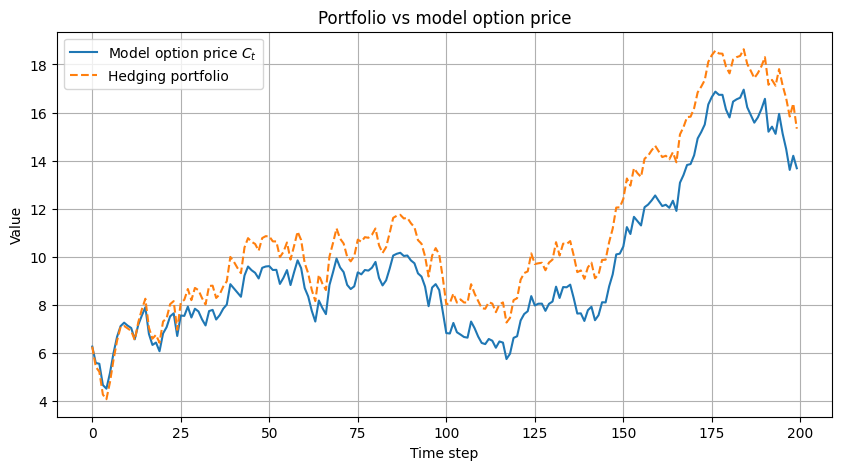

In [7]:
results=utils.hedging.delta_hedge(model=Heston_test, model_type='heston', K=100,N_paths=1, N_steps=200,T=0.5, S0=100, v0=0.05,seed=20)
# Warning, the simulation of the portfolio has no implementation for q != 0
import matplotlib.pyplot as plt
import numpy as np

S = results["S_path"][0]
portfolio = results["portfolio"][0]
C = results["opt_price"][0]  # directly from hedge results

plt.figure(figsize=(10,5))
plt.plot(C, label="Model option price $C_t$")
plt.plot(portfolio, '--', label="Hedging portfolio")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.title("Portfolio vs model option price")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
results['portfolio'][0], results['delta'][0]

(array([ 6.252819  ,  5.4104837 ,  5.20740371,  4.25522147,  4.06268222,
         4.77044499,  5.70135252,  6.49380769,  7.07403391,  7.11520498,
         7.01085258,  6.90807786,  6.52933798,  7.26666695,  7.79943416,
         8.24674852,  7.04424498,  6.58112055,  6.74290296,  6.41373546,
         7.29776994,  7.4370768 ,  8.02123182,  8.14682643,  6.95356975,
         8.07419312,  8.20407211,  8.65155582,  8.18804779,  8.69713477,
         8.60413167,  8.27509711,  8.0079489 ,  8.77914243,  8.79013432,
         8.28013469,  8.42969309,  8.75556025,  8.97419837,  9.98660406,
         9.78810654,  9.53127714,  9.31028126, 10.38072706, 10.76886121,
        10.61660779, 10.52858477, 10.24393287, 10.7722254 , 10.85166053,
        10.84214882, 10.63493597, 10.63174538,  9.97764353, 10.19648627,
        10.58859907,  9.87593291, 10.44017249, 11.04136521, 10.6895369 ,
         9.73161696,  9.30126521,  8.61431129,  8.14759298,  9.24169115,
         8.87610939,  8.60918348, 10.00240341, 10.5

In [9]:
# For comparison with delta in Rouah's book (price call= 7.8057, delta = 0.5501)
Heston_RouahDelta=models.heston.Heston(r=0.05, q=0.03, 
                                 kappa=0, 
                                 theta=0.07, 
                                 sigma=0.0001, 
                                 rho=-0.8)
Heston_RouahDelta.price_greeks(Lphi=0.00001, Uphi=50, dphi=0.001, K=100, tau=0.5, S=100, v=0.07)

{'call_price': np.float64(7.805653238583091),
 'delta': np.float64(0.55013819641897)}

In [10]:
Heston_test_q0=models.heston.Heston(r=0.03, q=0.0, 
                                 kappa=5.0, 
                                 theta=0.05, 
                                 sigma=0.5, 
                                 rho=-0.8)
Heston_test_q0.mc_price(N_paths=50000, N_steps=200, K=100, T=0.5, S0=100, v0=0.05,seed=20)

np.float64(6.891482806514103)

In [11]:
# Comparison with the price in Rouah's book price call = 6.8678
Heston_test_q0.cf_price(Lphi=0.00001, Uphi=50, dphi=0.001, K=100, tau=0.5, S=100, v=0.05)

np.float64(6.867834847668782)

path 0 finished
path 1 finished
path 2 finished
path 3 finished
path 4 finished
path 5 finished
path 6 finished
path 7 finished
path 8 finished
path 9 finished
0.33589349821046854 1.1864975308978232


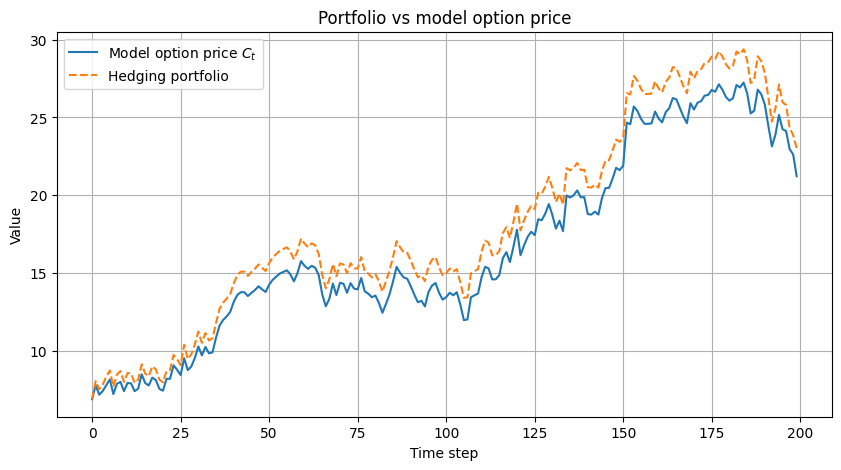

In [12]:
results=utils.hedging.delta_hedge(model=Heston_test_q0, model_type='heston', K=100,N_paths=10, N_steps=200,T=0.5, S0=100, v0=0.05,seed=5000)

import matplotlib.pyplot as plt
import numpy as np

S = results["S_path"][0]
portfolio = results["portfolio"][0]
C = results["opt_price"][0]  # directly from hedge results

plt.figure(figsize=(10,5))
plt.plot(C, label="Model option price $C_t$")
plt.plot(portfolio, '--', label="Hedging portfolio")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.title("Portfolio vs model option price")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
results['portfolio'][0], results['delta'][0]

(array([ 6.86783485,  8.04025191,  7.50775185,  7.80049678,  8.32963384,
         8.71160752,  7.66204509,  8.45971978,  8.6823224 ,  7.98396144,
         8.55097343,  8.53922465,  7.91718008,  8.13477022,  9.11169935,
         8.51941305,  8.34241405,  8.99247887,  8.78261732,  8.12562634,
         7.95354427,  8.67972484,  8.74134652,  9.71387946,  9.43660665,
         9.06599136, 10.37565119,  9.44914275,  9.75787358, 10.3780698 ,
        11.22270856, 10.4954323 , 11.11961391, 10.64747367, 10.79005948,
        11.77235813, 12.69068408, 13.07861784, 13.34402598, 13.6419728 ,
        14.32193008, 14.86273306, 15.07714685, 15.07919133, 14.79995837,
        15.06394923, 15.26887749, 15.54119472, 15.31930677, 15.12181523,
        15.63852586, 15.98760813, 16.21125574, 16.42682174, 16.5379497 ,
        16.64290986, 16.36175964, 15.86083983, 16.39265641, 17.20612459,
        16.88480929, 16.64477305, 16.89888909, 16.77051516, 16.21327702,
        14.8668588 , 14.00706368, 14.58617395, 15.5

## Double Heston Model

In [14]:
# --------------------------
# Module reload utility cell
# --------------------------
import importlib
import models.heston
import models.doubleheston
import plotting.plot_utils
import utils.hedging

# Reload modules to pick up edits
importlib.reload(models.heston)
importlib.reload(models.doubleheston)
importlib.reload(plotting.plot_utils)
importlib.reload(utils.hedging)

<module 'utils.hedging' from '/home/machine/Desktop/ErdosFinance2025/utils/hedging.py'>

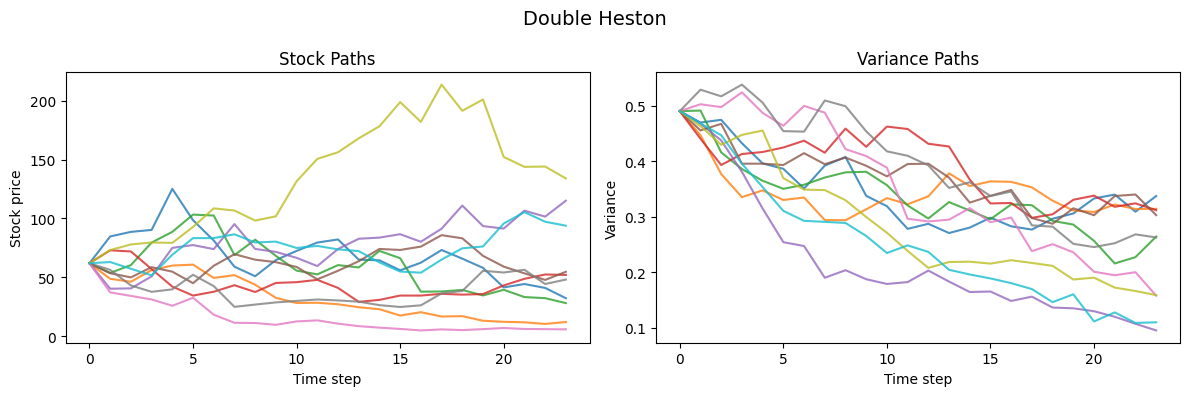

In [15]:
DoubleHeston_test=models.doubleheston.DoubleHeston(r=0.03, q=0.0,
                                                   kappa1=0.9, kappa2=1.2, 
                                                   theta1=0.1, theta2=0.15, 
                                                   sigma1=0.1, sigma2=0.2, 
                                                   rho1=-0.5, rho2=-0.5)

S_double, V1_double, V2_double = DoubleHeston_test.simulate_paths(N_paths=10,N_steps=24, T=1, S0=61.9, v01=0.6**2, v02=0.7**2, seed=20)

from plotting.plot_utils import plot_paths
plot_paths(S_double,V2_double, title='Double Heston')

In [16]:
DoubleHeston_test.mc_price(N_paths=100000, N_steps=1000, K=61.9, T=1, S0=61.9, v01=0.6**2, v02=0.7**2, seed=20)

np.float64(19.43242138500229)

In [17]:
DoubleHeston_test.cf_price(Lphi=0.0000001, Uphi=100, dphi=0.0001, K=61.9, tau=1, S=61.9, v1=0.6**2, v2=0.7**2)

np.float64(19.45378032050505)

In [18]:
# Compares with cf_price and the value in Rouah's book for delta (0.6730), price call = 19.4538
DoubleHeston_test.price_greeks(Lphi=0.0000001, Uphi=100, dphi=0.0001, K=61.9, tau=1, S=61.9, v1=0.6**2, v2=0.7**2)

{'call_price': np.float64(19.45378032050505),
 'delta': np.float64(0.6729675032920192)}

path 0 finished
-1.420213484211183 0.0


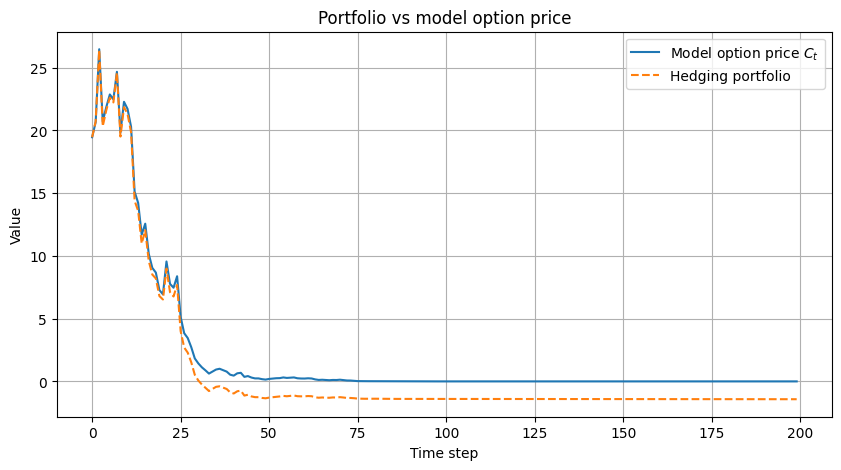

In [19]:
results=utils.hedging.delta_hedge(model=DoubleHeston_test, model_type='doubleheston', K=61.9, N_paths=1, N_steps=200,T=1, 
                                          S0=61.9, v01=0.6**2, v02=0.7**2,seed=20)

import matplotlib.pyplot as plt
import numpy as np

S = results["S_path"][0]
portfolio = results["portfolio"][0]
C = results["opt_price"][0]  # directly from hedge results

plt.figure(figsize=(10,5))
plt.plot(C, label="Model option price $C_t$")
plt.plot(portfolio, '--', label="Hedging portfolio")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.title("Portfolio vs model option price")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
results['portfolio'][0], results['delta'][0]

(array([19.45366289, 20.71539466, 26.39795667, 20.33269442, 21.61047806,
        22.6090544 , 22.22785124, 24.59961547, 19.50912534, 21.84953467,
        21.3159121 , 19.85333389, 14.39105284, 13.58695121, 10.98337646,
        12.04698749,  9.58688561,  8.51198484,  8.20096656,  6.80000378,
         6.52745232,  8.990675  ,  7.10927766,  6.76593118,  7.6884201 ,
         4.00675732,  2.70052233,  2.29221202,  1.52055796,  0.52203281,
         0.06857802, -0.2463534 , -0.50951725, -0.76882973, -0.60559075,
        -0.43230961, -0.39156571, -0.49945409, -0.60387926, -0.87727563,
        -0.96397856, -0.78564309, -0.73740986, -1.12951868, -1.06308988,
        -1.19766281, -1.25531679, -1.25665301, -1.31776345, -1.34678692,
        -1.29124919, -1.26090207, -1.2246381 , -1.19864469, -1.15544479,
        -1.18407101, -1.15139255, -1.12222198, -1.18017502, -1.19043658,
        -1.18845455, -1.16656526, -1.18113744, -1.27048326, -1.3010339 ,
        -1.28080378, -1.30051724, -1.3039589 , -1.2

### Monte Carlo Simulations (Double Heston)

#### Brownian motions

Describe how the Brownian motions are simulated.

#### Euler Scheme (Double Heston)

Describe the Euler scheme for the SDEs.

#### Simulations (Double Heston)

In [21]:
#Code goes here
# simulate_paths(S0, v0_1, v0_2, r, kappa1, theta1, sigma1, rho1,kappa2, theta2, sigma2, rho2, rho12, T, N_steps, N_paths)
# mc_price(S_paths, K, r, T, option_type='call')

In [22]:
# Path simulations

### Exact Price (Double Heston)

Formulas go here.

In [23]:
# Code goes here
# dobleheston_cf_price(S0,v0_1, v0_2,r,kappa1, theta1, sigma1, rho1,
# kappa2, theta2, sigma2, rho2,rho12,T, K) # not so sure about the arguments for this one, but we'll find out

In [24]:
# Comparison between Monte Carlo and exact price

## References

Heston, S.L., 1993. A closed-form solution for options with stochastic volatility with applications to bond and currency options. The review of financial studies, 6(2), pp.327-343.

Rouah, F.D., 2013. The Heston model and its extensions in Matlab and C. John Wiley & Sons.